# Explore features

In [1]:
import os.path as osp
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import numpy.linalg as npl
sys.path.append("../src")
from score_utils import *

In [2]:
root = osp.join('..', 'outputs', 'resnet_cifar100_20201222_154825')
# root = osp.join('..', 'outputs', 'densenet_cifar10_20201223_164119')


In [18]:
model_name, trainset_name = osp.basename(root).split("_")[0:2]
print(model_name, trainset_name)

# Load IND products
trainset_features, ind_features, ind_labels = load_ind_products(root, model_name, trainset_name)
w = load_fc_layer(root)


# Score max prob
ind_probs = calc_probs(ind_features, w)
max_probs_ind = np.max(ind_probs, axis=1)

# Score pNML
trainset_features = transform_features(trainset_features)
ind_features = transform_features(ind_features)
ind_probs = calc_probs(ind_features, w)
p_parallel, p_bot = calc_projection_matrices(trainset_features)
regrets_ind, pnml_prediction = calc_regret_on_set(ind_features, ind_probs, p_parallel, p_bot)

x_parallel_square_ind = np.array([x @ p_parallel @ x.T for x in ind_features])
x_bot_square_ind = np.array([x @ p_bot @ x.T for x in ind_features])

# Print performance on IND set
max_prob_acc = np.mean(np.argmax(ind_probs, axis=1) == ind_labels)
pnml_acc = np.mean(np.argmax(pnml_prediction, axis=1) == ind_labels)
print(f"Acc [ERM pNML]=[{max_prob_acc} {pnml_acc}]")

# Load OOD products
ood_dict = load_ood_products(root, model_name, trainset_name)

ood_features_list, ood_regrets_list = [], []
x_parallel_ood_list, x_bot_ood_list = [], []
for ood_name, feature_path in tqdm(ood_dict.items()):

    # Compute pNML
    ood_features = load_features(feature_path)
    ood_features = transform_features(ood_features)
    ood_probs = calc_probs(ood_features, w)
    regrets_ood, _ = calc_regret_on_set(ood_features, ood_probs, p_parallel, p_bot)

    ood_features_list.append(ood_features)
    ood_regrets_list.append(regrets_ood)

    x_parallel_square_ood = np.array([x @ p_parallel @ x.T for x in ood_features])
    x_bot_square_ood = np.array([x @ p_bot @ x.T for x in ood_features])
    x_parallel_ood_list.append(x_parallel_square_ood)
    x_bot_ood_list.append(x_bot_square_ood)

resnet cifar100
Features: [trainset testset]=[(50000, 513) (10000, 513)]


  0%|          | 0/5 [00:00<?, ?it/s]

Acc [ERM pNML]=[0.7841 0.7841]


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


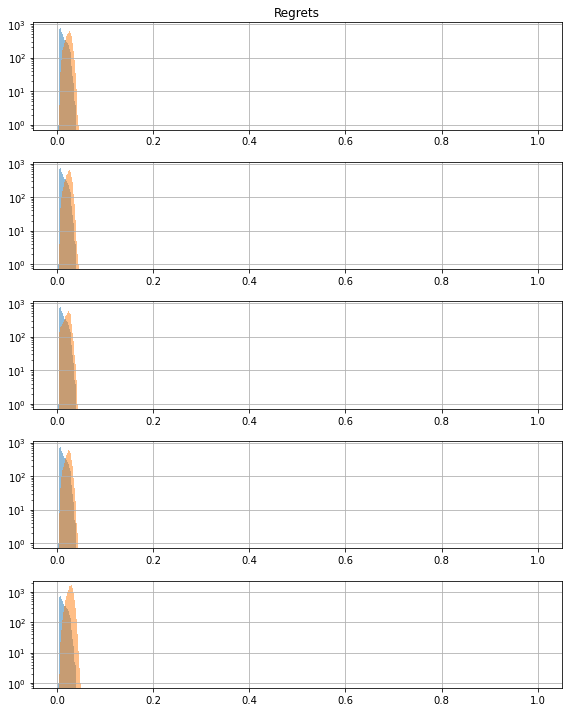

In [4]:
fig, axs = plt.subplots(len(ood_dict), figsize=(8, 10))

bins = np.linspace(0, 1.0, 1000)
for i, ood_regrets in enumerate(ood_regrets_list):
    ax = axs[i]
    ax.hist(regrets_ind, label="IND", bins=bins, alpha=0.5)
    ax.hist(ood_regrets, label="OOD", bins=bins, alpha=0.5)
    ax.grid()
    ax.set_yscale('log')
axs[0].set_title("Regrets")
plt.tight_layout()
plt.show()

In [5]:
trainset_features, ind_features, ind_labels = load_ind_products(root, model_name, trainset_name)
trainset_norms = npl.norm(trainset_features, axis=1)
testset_norms = npl.norm(ind_features, axis=1)
print(
    "Trainset: [min max avg]=[{:.2f} {:.2f} {:.2f}]".format(
        trainset_norms.min(), trainset_norms.max(), trainset_norms.mean()
    )
)
print(
    "Testset: [min max avg]=[{:.2f} {:.2f} {:.2f}]".format(
        testset_norms.min(), testset_norms.max(), testset_norms.mean()
    )
)

ood_dict = load_ood_products(root, model_name, trainset_name)

ood_norms_list = []
for ood_name, feature_path in tqdm(ood_dict.items()):

    # Compute pNML
    ood_features = load_features(feature_path)
    ood_norms = npl.norm(ood_features, axis=1)
    ood_norms_list.append(ood_norms)

    print(
        "{}: [min max]=[{:.2f} {:.2f} {:.2f}]".format(
            ood_name, ood_norms.min(), ood_norms.max(), ood_norms.mean()
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Features: [trainset testset]=[(50000, 513) (10000, 513)]
Trainset: [min max avg]=[6.10 19.75 11.29]
Testset: [min max avg]=[5.38 15.97 10.24]


 80%|████████  | 4/5 [00:00<00:00, 33.82it/s]

Imagenet_resize: [min max]=[5.65 14.18 9.50]
LSUN_resize: [min max]=[5.47 15.70 9.59]
cifar10: [min max]=[5.31 14.65 9.68]
iSUN: [min max]=[5.86 15.37 9.58]


100%|██████████| 5/5 [00:00<00:00, 18.41it/s]

svhn: [min max]=[5.20 15.48 10.11]


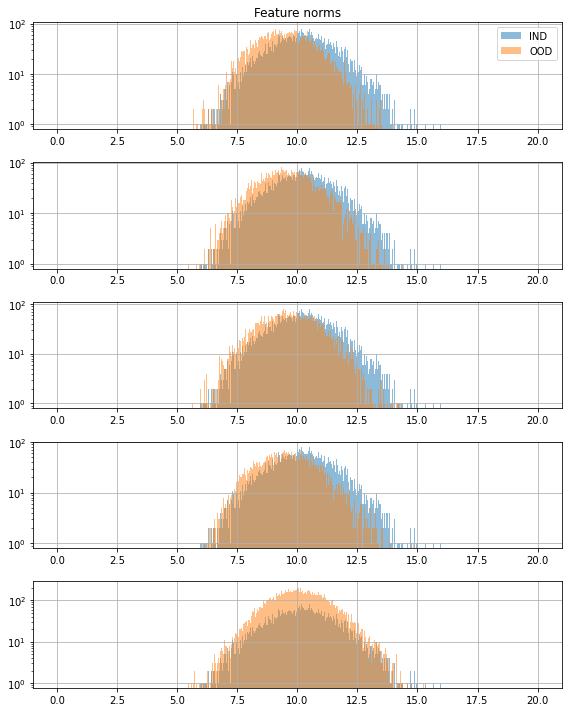

In [7]:
fig, axs = plt.subplots(len(ood_dict), figsize=(8, 10))

bins = np.linspace(0, 20, 1000)
for i, ood_norms in enumerate(ood_norms_list):
    ax = axs[i]
    ax.hist(testset_norms, label="IND", bins=bins, alpha=0.5)
    ax.hist(ood_norms, label="OOD", bins=bins, alpha=0.5)
    ax.grid()
    ax.set_yscale("log")
axs[0].set_title("Feature norms")
axs[0].legend()
plt.tight_layout()
plt.show()

0.00518445251696781 0.048677652875148324
0.00506725185594107 0.04755530823966529
0.0032150107774487824 0.04508998787586241
0.004378143066872374 0.04523919321562779
0.005737054653957839 0.05116362119111234


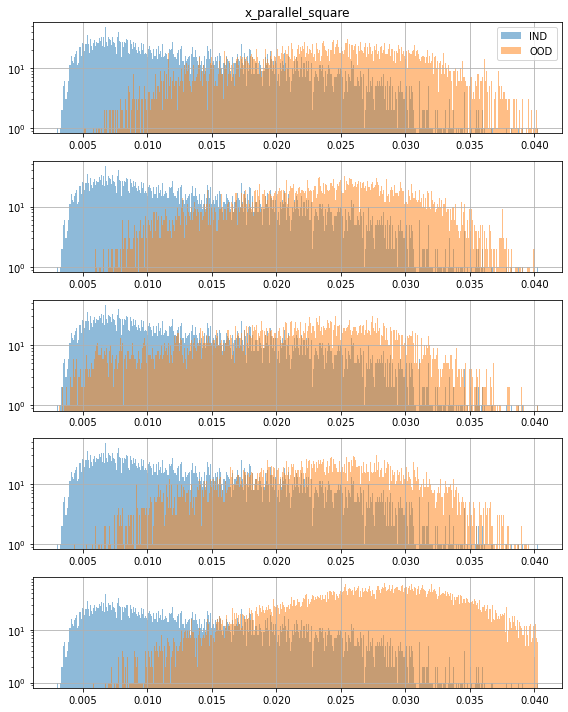

In [26]:
fig, axs = plt.subplots(len(ood_dict), figsize=(8, 10))

for i in range(len(ood_dict)):
    ax = axs[i]
    _, bins, _ = ax.hist(
        x_parallel_square_ind / (1 + x_parallel_square_ind), bins=1000, label="IND", alpha=0.5
    )
    ax.hist(
        x_parallel_ood_list[i] / (x_parallel_ood_list[i] + 1), label="OOD", bins=bins, alpha=0.5
    )
    ax.grid()
    ax.set_yscale("log")

    print(x_parallel_ood_list[i].min(), x_parallel_ood_list[i].max())
axs[0].set_title("x_parallel_square")
axs[0].legend()
plt.tight_layout()
plt.show()

-3.3540484923951302e-12 4.2234331083816165e-12
-3.627379256638651e-12 3.959824709925155e-12
-3.4426478190764906e-12 3.3700342667609446e-12
-4.047485215660893e-12 3.8953565823624605e-12
-3.7114670451342284e-12 3.3513460335220957e-12


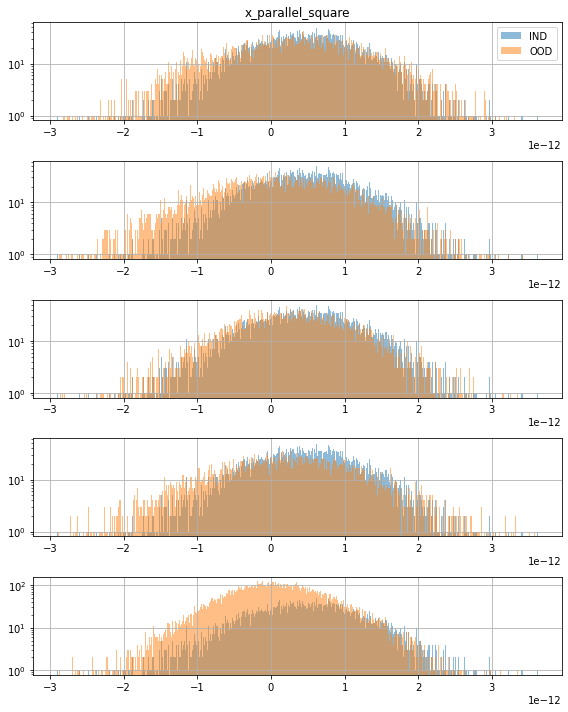

In [25]:
fig, axs = plt.subplots(len(ood_dict), figsize=(8, 10))

for i in range(len(ood_dict)):
    ax = axs[i]
    _, bins, _ = ax.hist(x_bot_square_ind, bins=1000, label="IND", alpha=0.5)
    ax.hist(x_bot_ood_list[i], label="OOD", bins=bins, alpha=0.5)
    ax.grid()
    ax.set_yscale("log")

    print(x_bot_ood_list[i].min(), x_bot_ood_list[i].max())
axs[0].set_title("x_parallel_square")
axs[0].legend()
plt.tight_layout()
plt.show()

In [17]:
# Worst ind
idx = np.argmax(regrets_ind)
feature_ind = ind_features[idx]

idx = np.argmin(regrets_ood)
feature_ood = ood_features[idx]

x_parallel_square = feature_ind @ p_parallel @ feature_ind.T
x_bot_square = feature_ind @ p_bot @ feature_ind.T
print(x_parallel_square,x_bot_square)

x_parallel_square = feature_ood @ p_parallel @ feature_ood.T
x_bot_square = feature_ood @ p_bot @ feature_ood.T
print(x_parallel_square,x_bot_square)

0.04194188854849164 1.121382615972813e-13
0.005737054653957839 4.792206324721094e-13


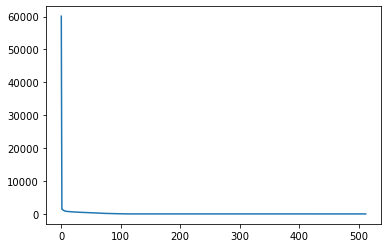

In [29]:
plt.plot(npl.svd(trainset_features.T @ trainset_features)[1])